In [1]:
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torchvision as tv
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
use_amp = True
batch_size = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
trans = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize((224, 224),  antialias=True)
])

In [4]:
# train = tv.datasets.Food101('./', download=True, transform=trans, split="train")
# test = tv.datasets.Food101('./', download=True, transform=trans, split="test")
# train = tv.datasets.CIFAR100('./', download=True, transform=trans, train=True)
# test = tv.datasets.CIFAR100('./', download=True, transform=trans, train=False)
train = tv.datasets.CIFAR10('./', download=True, transform=trans, train=True)
test = tv.datasets.CIFAR10('./', download=True, transform=trans, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
labels = torch.zeros(len(train.classes), dtype=torch.long)

for _, target in train:
    labels[target-1]+=1

print(labels)

tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])


In [6]:
len(labels)

10

In [7]:
train[1000][0].shape

torch.Size([3, 224, 224])

frog


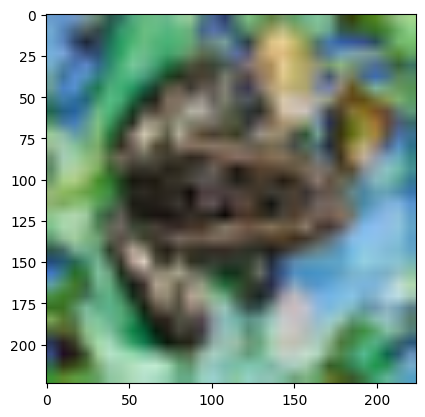

In [8]:
plt.imshow(train[200][0].permute(1, 2, 0))
print(train.classes[train[200][1]])

In [9]:
train_dataloader = torch.utils.data.DataLoader(train,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=1,
                                         drop_last=True)

In [10]:
for i, j in train_dataloader:
    print(i.shape)
    print(j.shape)
    break

torch.Size([30, 3, 224, 224])
torch.Size([30])


In [11]:
def padding_calc(input_matrix_shape: tuple, out_matrix_shape: tuple, kernel_size:tuple, stride:int) -> tuple:

    padding_h = (stride * (out_matrix_shape[0] - 1) - input_matrix_shape[0] +
                 kernel_size[0]) / 2
    padding_w = (stride * (out_matrix_shape[1] - 1) - input_matrix_shape[1] +
                 kernel_size[1]) / 2

    return padding_h, padding_w

In [12]:
class VGGB(torch.nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.num_classes = num_classes

        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_1_1 = torch.nn.Conv2d(in_channels=3,
                                        out_channels=64,
                                        kernel_size=3,
                                        padding=1)
        self.conv_1_2 = torch.nn.Conv2d(in_channels=64,
                                        out_channels=64,
                                        kernel_size=3,
                                        padding=1)
        self.conv_2_1 = torch.nn.Conv2d(in_channels=64,
                                        out_channels=128,
                                        kernel_size=3,
                                        padding=1)
        self.conv_2_2 = torch.nn.Conv2d(in_channels=128,
                                        out_channels=128,
                                        kernel_size=3,
                                        padding=1)
        self.conv_3_1 = torch.nn.Conv2d(in_channels=128,
                                        out_channels=256,
                                        kernel_size=3,
                                        padding=1)
        self.conv_3_2 = torch.nn.Conv2d(in_channels=256,
                                        out_channels=256,
                                        kernel_size=3,
                                        padding=1)
        self.conv_4_1 = torch.nn.Conv2d(in_channels=256,
                                        out_channels=512,
                                        kernel_size=3,
                                        padding=1)
        self.conv_4_2 = torch.nn.Conv2d(in_channels=512,
                                        out_channels=512,
                                        kernel_size=3,
                                        padding=1)
        self.conv_5_1 = torch.nn.Conv2d(in_channels=512,
                                        out_channels=512,
                                        kernel_size=3,
                                        padding=1)
        self.conv_5_2 = torch.nn.Conv2d(in_channels=512,
                                        out_channels=512,
                                        kernel_size=3,
                                        padding=1)

        self.flat = torch.nn.Flatten()

        self.fulc_1 = torch.nn.Linear(7*7*512, 4096)
        self.fulc_2 = torch.nn.Linear(4096, 4096)
        self.fulc_3 = torch.nn.Linear(4096, self.num_classes)

    def forward(self, x):
        out = self.conv_1_1(x)
        out = self.conv_1_2(out)
        out = self.maxpool(out)

        out = self.conv_2_1(out)
        out = self.conv_2_2(out)
        out = self.maxpool(out)

        out = self.conv_3_1(out)
        out = self.conv_3_2(out)
        out = self.maxpool(out)

        out = self.conv_4_1(out)
        out = self.conv_4_2(out)
        out = self.maxpool(out)

        out = self.conv_5_1(out)
        out = self.conv_5_2(out)
        out = self.maxpool(out)

        out = self.flat(out)
        out = self.fulc_1(out)
        out = self.fulc_2(out)
        out = self.fulc_3(out)

        return out


In [13]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
model = VGGB(len(train.classes))
model = model.to(device)

In [15]:
count_parameters(model)

128991818

In [14]:
loss_fn = torch.nn.CrossEntropyLoss()
loss = loss_fn.to(device)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3, weight_decay=0.001)

In [16]:
scaler = torch.cuda.amp.GradScaler()

In [17]:
epochs = 1

for epoch in range(epochs):
    for img, label in (pbar := tqdm(train_dataloader)):
        optimizer.zero_grad()

        img = img.to(device)
        label = label.to(device)

        with autocast(use_amp):
            pred = model(img)
            loss = loss_fn(pred, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        

 13%|█▎        | 216/1666 [04:01<27:01,  1.12s/it]


KeyboardInterrupt: 

In [18]:
label.cpu()

tensor([3, 4, 2, 8, 1, 0, 4, 4, 3, 7, 9, 6, 8, 6, 0, 5, 7, 9, 5, 8, 6, 9, 3, 1,
        3, 2, 9, 9, 4, 1])

In [19]:
pred.detach().cpu().argmax(1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])